In [1]:
from poloniex import Poloniex
from tusp import string2ts, ts2string
import json
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

polo = Poloniex()

# historyData es una lista de diccionarios python
# candlestick period in seconds; valid values are 300, 900, 1800, 7200, 14400, and 86400
historyData = polo.returnChartData(currencyPair="BTC_XRP",
                     start=string2ts("2017-06-01 00:00:00"),
                     end=string2ts("2017-06-02 00:00:00"),
                     period=300)

# Guardando los datos como lista de diccionarios en un archivo de texto
# esto permite acceder a ellos y trabajar como data frame offline
with open("XMR_data.out","w") as f:
    json.dump(historyData,f)
    
with open("XMR_data.out") as f:
    historyData = json.load(f)
    #print data

# convirtiendo datos en data frame
df = pd.DataFrame(historyData)

#  convirtiendo string a float o int
df["close"] =pd.to_numeric(df['close'])
df["open"] =pd.to_numeric(df['open'])
df["low"] =pd.to_numeric(df['high'])
df["volume"] =pd.to_numeric(df['volume'])
df["date"] = pd.to_datetime(df["date"].apply(ts2string))

# seleccionando la columna de fecha como indice
df = df.set_index("date")

# examinando las primeras filas
df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-06-01 00:00:00,0.000108,0.0001082,0.000108,0.000107,1609135.7429412,172.164903,0.00010699
2017-06-01 00:05:00,0.000108,0.00010873,0.000109,0.000108,1104558.4010327,119.581267,0.00010826
2017-06-01 00:10:00,0.000107,0.00010825,0.000108,0.000108,828505.59255469,89.041958,0.00010747
2017-06-01 00:15:00,0.000107,0.00010732,0.000107,0.000107,921722.01395872,98.570024,0.00010694
2017-06-01 00:20:00,0.000107,0.00010699,0.000107,0.000107,618682.26933289,66.036618,0.00010673


# Calculando retornos, log retornos y sus respectivos acumulados

Retorno final del mercado: 29.0477954798


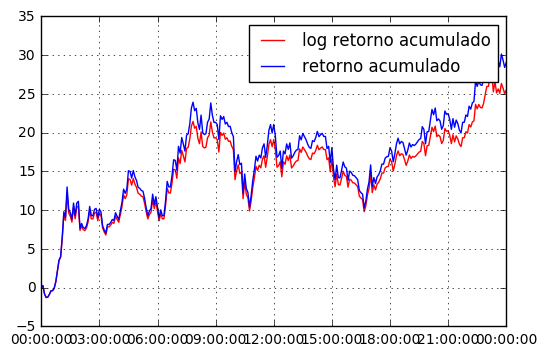

In [2]:
# Calculando retornos relativos
# el 1 se refiere al numero de periodos que se toma para calcular el cambio porcentual
df["retornos relativos"] = df["close"].pct_change(1).fillna(0)

# calculando los log retornos
df["log retornos"] = np.log(df["close"]).diff().fillna(0)

# calculando log retorno acumulado
df["cum_logr"] = df["log retornos"].cumsum()
df["cum_r"] = np.exp(df["cum_logr"]) - 1

plt.plot(df.index,df['cum_logr']*100,'r',label='log retorno acumulado')
plt.plot(df.index,df['cum_r']*100,'b', label='retorno acumulado')
plt.legend()
plt.grid()
#df.isnull().any()
#df[df['retornos relativos'].isnull()]
print "Retorno final del mercado: %s"%(df["cum_r"][-1]*100)

# Ejemplo estrategía, media movil

Las estrategías funcionan como funciones que como parámetro reciben una serie de pandas o una lista de tamaño $T$ (intervalo de tiempo de estudio divido en el periodo de interés), y devuelven el vector de pesos $\vec{w}$ de tamaño $T\times 2$ y que contiene solo ceros o unos (1 si se posee el determinado activo, 0 si no). La primera columna de $\vec{w}$ corresponde a la posesión del activo de interés, la segunda a la posesión de la moneda por la que se tranza (generalmente **BTC**) 

El retorno relativo con la estrategia EMA5 VS SMA20 fue: 38.0240659932
                       w orders
date                           
2017-06-01 00:00:00  0.0   WAIT
2017-06-01 00:05:00  0.0   WAIT
2017-06-01 00:10:00  0.0   WAIT
2017-06-01 00:15:00  0.0   WAIT
2017-06-01 00:20:00  0.0   WAIT
2017-06-01 00:25:00  0.0   WAIT
2017-06-01 00:30:00  0.0   WAIT
2017-06-01 00:35:00  1.0    BUY
2017-06-01 00:40:00  1.0   WAIT
2017-06-01 00:45:00  1.0   WAIT
2017-06-01 00:50:00  1.0   WAIT
2017-06-01 00:55:00  1.0   WAIT
2017-06-01 01:00:00  1.0   WAIT
2017-06-01 01:05:00  1.0   WAIT
2017-06-01 01:10:00  1.0   WAIT
2017-06-01 01:15:00  1.0   WAIT
2017-06-01 01:20:00  1.0   WAIT
2017-06-01 01:25:00  1.0   WAIT
2017-06-01 01:30:00  1.0   WAIT
2017-06-01 01:35:00  1.0   WAIT
2017-06-01 01:40:00  1.0   WAIT
2017-06-01 01:45:00  1.0   WAIT
2017-06-01 01:50:00  1.0   WAIT
2017-06-01 01:55:00  1.0   WAIT
2017-06-01 02:00:00  1.0   WAIT
2017-06-01 02:05:00  0.0   SELL
2017-06-01 02:10:00  0.0   WAIT
2

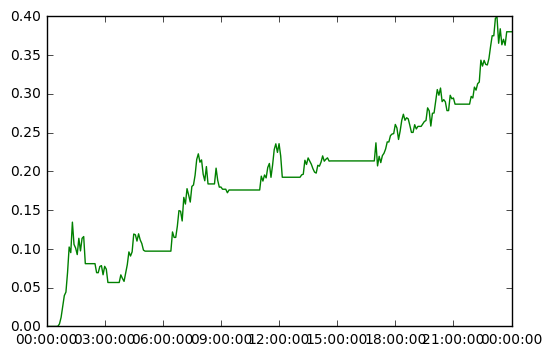

In [6]:
from profit import profit,change5
from orders import orders

# dada una serie de pandas o una lista y el numero de muestras para la EMA y SMA devuelve vector w
# considerando el cruce entre EMA y SMA
def estrategiaEMAvsSMA(serie, smaPeriod=13,emaPeriod=5):
    
    # Calculando media movil a 20 muestras
    sma = serie.rolling(smaPeriod,min_periods=1).mean()
    # caculando exponential movil average
    ema = serie.ewm(span=emaPeriod, adjust=False).mean()
    
    # Encontrando el signo de la resta entre ellas para encontrar los cruces
    dif = (ema - sma).apply(np.sign)
    
    w = pd.DataFrame(data={"w":(dif+1)/2})
    
    w['w'] = w['w'].apply(change5)
    
    w["orders"] = orders(w["w"])
    """
    plt.plot(df.index,df['close'],'g',label='precio')
    plt.plot(df.index,ema,'r',label='EMA')
    plt.plot(df.index,sma,'b',label='SMA')
    plt.legend(loc='best')
    plt.grid()
    """
    return w



w = estrategiaEMAvsSMA(df['close'])
relativeReturn, vecReturn = profit(w["w"],df["close"])

plt.plot(df.index,vecReturn,'g',label='retorno')


print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)
print w



## Probando otras versiones de la estrategia de cruce de medias

El mejor desempeño en las estrategias de medias moviles para el par XRP_BTC entre 1/06/2017 y el 1/09/2017 con precio de un día, lo obtuvo price vs EMA_5, con un profit de 239.78%. El mercado en cambio tuvo un profit de -62.77% en el mismo periodo.
***Intervalo precio, profit price vs EMA_5, profit market*** 
<br>
* 1d, 239.78%, -62.77%
* 4h, 2.937%, -53.9%
* 2h, 17.655.12%, -55.11%
* 30m, 12'202.905%, -49.58% 

TypeError: not all arguments converted during string formatting

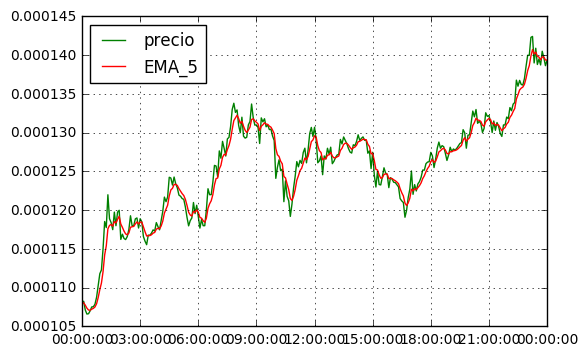

In [4]:
from strategy import pricevsEMA, pricevsSMA, EMAvsEMA

#Precio vs EMA_5

w = pricevsEMA(df["close"])
relativeReturn = profit(w["w"],df["close"])

print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)

In [ ]:
#Precio vs SMA_20

w = pricevsSMA(df["close"])
relativeReturn = profit(w["w"],df["close"])

print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)

In [ ]:
#EMA_5 vs EMA_20

w = EMAvsEMA(df["close"])
relativeReturn = profit(w["w"],df["close"])

print 'El retorno relativo con la estrategia EMA5 VS EMA20 fue: %s'%(relativeReturn*100)